Welcome to JupyROOT 6.29/01


Info in <TCanvas::Print>: png file loading_hist.png has been created


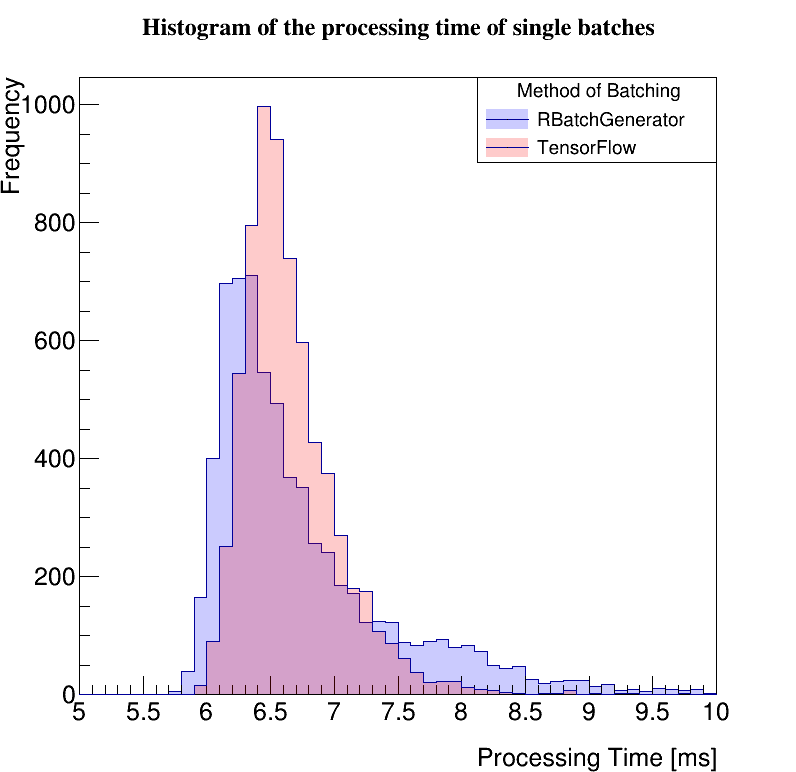

In [1]:

import numpy as np
import ROOT

data_root = []
data_all = []

bins = 50
h_root = ROOT.TH1F("root", "Histogram of the processing time of single batches", bins, 5, 10)
h_all = ROOT.TH1F("all", "all", bins, 5, 10)


with open("results/Tensorflow_ROOT_5_100000_train.csv", "r") as rf:
    for l in rf.readlines():
        h_root.Fill(float(l.strip()) * 1000)
        
with open("results/Tensorflow_uproot_5_train.csv", "r") as rf:
    for l in rf.readlines():
        h_all.Fill(float(l.strip()) * 1000)

h_root_max = h_root.GetMaximum()
h_all_max = h_all.GetMaximum()

max_y = max(h_root_max, h_all_max)

c = ROOT.TCanvas("canvas", "canvas", 800, 800)

h_root.GetYaxis().SetRangeUser(0, max_y + 50)

h_root.SetFillColorAlpha(4, 0.2)
h_all.SetFillColorAlpha(2, 0.2)

h_root.SetStats(0)
h_all.SetStats(0)

h_root.GetXaxis().SetTitle("Processing Time [ms]")
h_root.GetXaxis().SetTitleOffset(1.5)
h_root.GetYaxis().SetTitle("Frequency")
h_root.GetYaxis().SetTitleOffset(1.5)

h_root.Draw()
h_all.Draw("SAME")

legend = ROOT.TLegend(.6,.9,.9,.79)
legend.SetHeader("Method of Batching", "C")
legend.AddEntry(h_root, "RBatchGenerator")
legend.AddEntry(h_all, "TensorFlow")
legend.Draw()

ROOT.gStyle.SetTitleFont(20, "t")
c.Draw()
c.SaveAs("loading_hist.png")

##################################################################



In [5]:
import pandas as pd

df = pd.read_csv("results/memory.csv")

df["num_events"] = df["num"] * 2_000_000

df["maxresident"] = df["maxresident"] / 1_000_000 
df = df[df["num"] < 13]

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file memory_scaling.png has been created


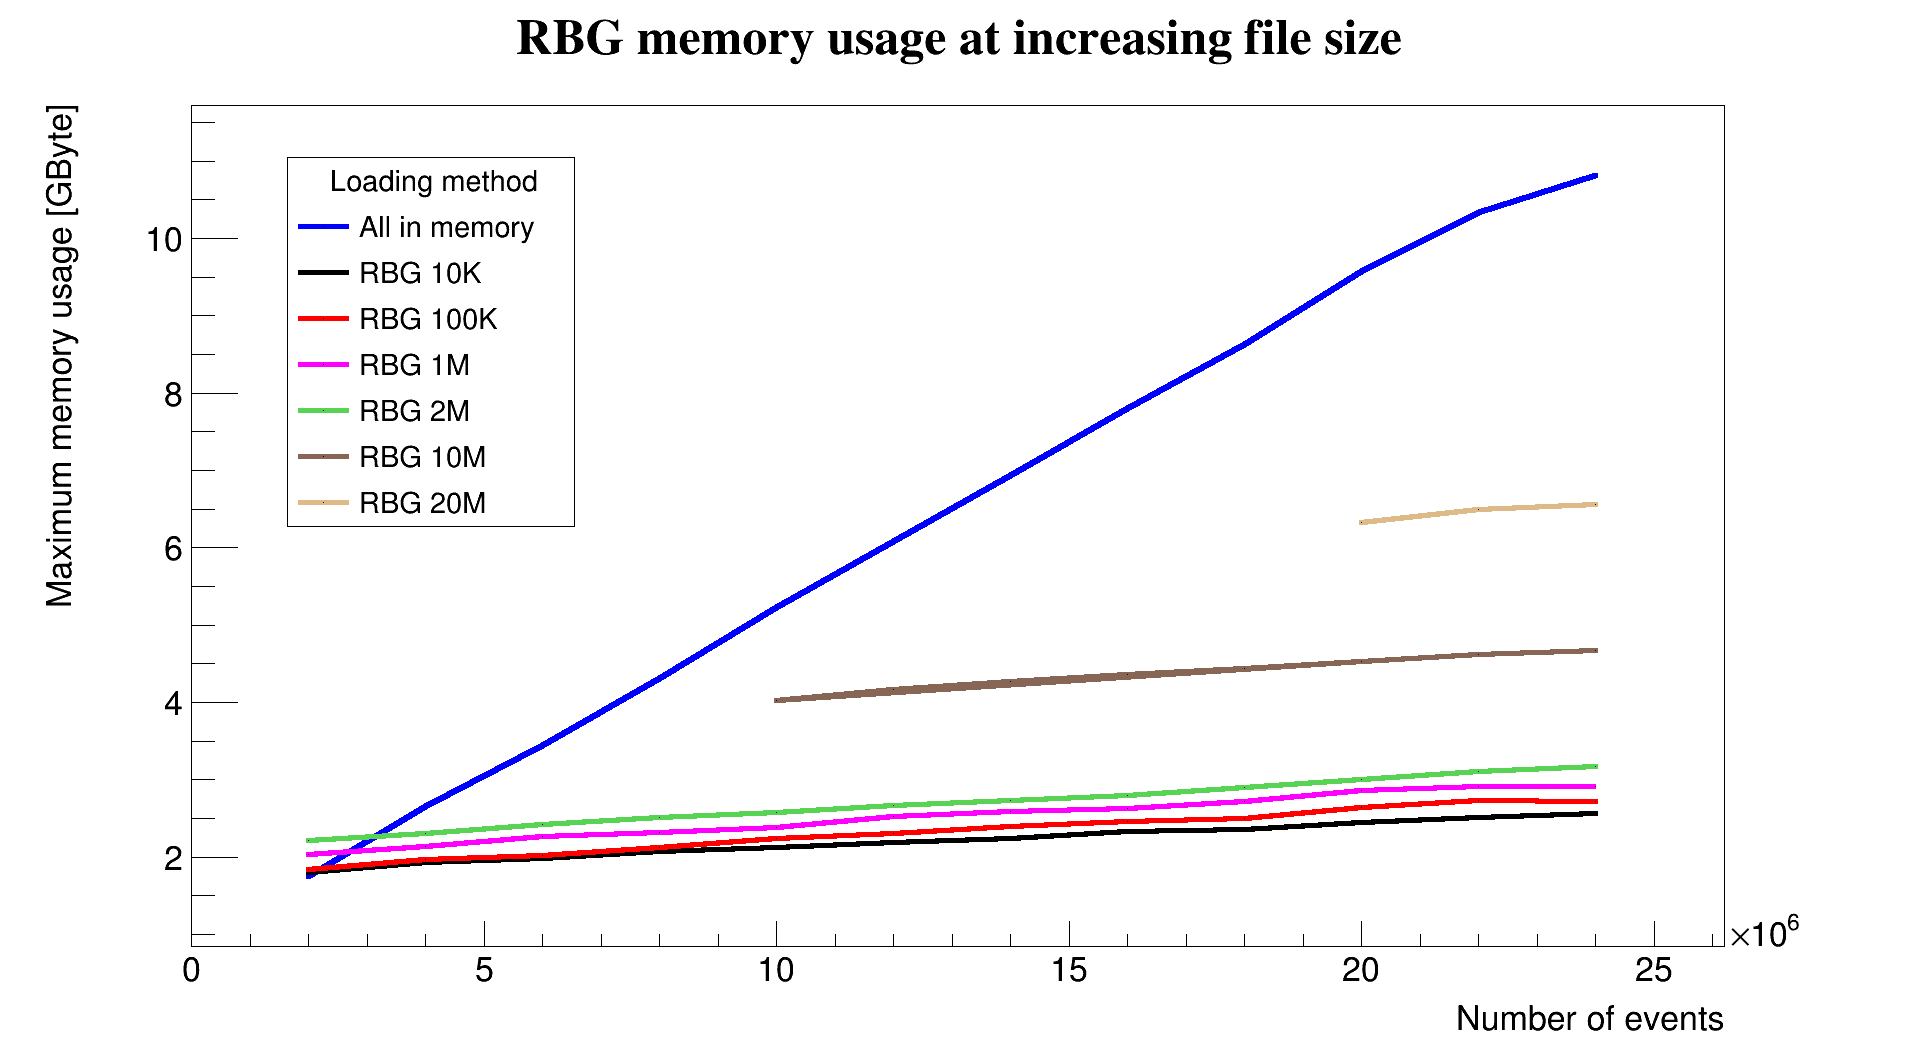

In [7]:
df_uproot = df[df.method == "uproot"]

df_ROOT = df[df.method == "ROOT"]

graph_uproot = ROOT.TGraph(len(df_uproot),
                                  np.array(df_uproot["num_events"], dtype=float),
                                  np.array(df_uproot["maxresident"], dtype=float))

width = 1920
height = 1080
line_width = 5

c = ROOT.TCanvas("c", "", width, height)
legend = ROOT.TLegend(0.15,0.5,0.3,0.85)
legend.SetHeader("Loading method", "C")

# graph_1partspercore.SetMarkerColor(ROOT.kBlue)
# graph_1partspercore.SetMarkerSize(2)
# graph_1partspercore.SetMarkerStyle(20)
graph_uproot.SetLineColorAlpha(ROOT.kBlue,1)
graph_uproot.SetLineWidth(line_width)

graph_uproot.GetXaxis().SetTitle("Number of events")
graph_uproot.GetXaxis().SetTitleOffset(1.2)
graph_uproot.GetYaxis().SetTitle("Maximum memory usage [GByte]")
graph_uproot.GetYaxis().SetTitleOffset(1.2)
graph_uproot.SetTitle("RBG memory usage at increasing file size")
# graph_uproot.SetTitleSize(.5)

graph_uproot.Draw("ALP")

legend.AddEntry(graph_uproot, "All in memory")

graphs = []
graph_colors = [1,2,6,8,28,42]
graph_names = ["RBG 10K", "RBG 100K", "RBG 1M", "RBG 2M", "RBG 10M", "RBG 20M"]
for i, (g, r) in enumerate(df_ROOT.groupby("chunksize")):
    graphs.append(ROOT.TGraph(len(r),
                                  np.array(r["num_events"], dtype=float),
                                  np.array(r["maxresident"], dtype=float)))
    
    graphs[i].SetLineColorAlpha(graph_colors[i], 1)
    graphs[i].SetLineWidth(line_width)
    graphs[i].Draw("SAME PL")
    
    legend.AddEntry(graphs[i], graph_names[i])


legend.Draw()

ROOT.gStyle.SetLegendTextSize(0.03)
ROOT.gStyle.SetTitleFont(20, "t")
c.Draw()
c.SaveAs("memory_scaling.png")